<a href="https://colab.research.google.com/github/AnguieGarciaB/topicosanalitica/blob/main/Graphs_Project_classification_facebook_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Graph Machine Learning

The dataset I have chosen to use is the [Facebook Large Page-Page Network dataset](https://snap.stanford.edu/data/facebook-large-page-page-network.html). It contains 22,470 Facebook pages classified into one of four classes, and there are 171,002 links in the network. Each page is represented by a vector of features.

The dataset has three separate files:
1. `musae_facebook_edges.csv`: This file contains the graph with two columns:
  - `id_1`: target node
  - `id_2`: source node
2. `musae_facebook_target.csv`: This file contains the descriptions and page type (label) of the 22,470 Facebook pages:
  - `id`
  - `facebook_id`
  - `page_name`: description
  - `page_type`: multi-class label (4 classes) that we're trying to predict.
3. `musae_facebook_features.json`: This file contains feature vectors for each Facebook page.

## Load Data

In [3]:
import urllib.request
import zipfile
import json
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops

In [4]:
url = "https://snap.stanford.edu/data/facebook_large.zip"
save_path = "./data/facebook_large.zip"
data_dir = "./data/facebook_large"

os.makedirs(os.path.dirname(save_path), exist_ok=True)
urllib.request.urlretrieve(url, save_path)

with zipfile.ZipFile(save_path, "r") as zip_ref:
  zip_ref.extractall(path=os.path.dirname(save_path))

## EDA on Dataset

In [5]:
# Import edges file as a dataframe
df_edges = pd.read_csv(os.path.join(data_dir, "musae_facebook_edges.csv"),).rename(columns={"id_1": "fb_site_id", "id_2": "follower_fb_site_id"})
print(df_edges.shape)
df_edges.head()

(171002, 2)


,fb_site_id,follower_fb_site_id
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [6]:
df_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171002 entries, 0 to 171001
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   fb_site_id           171002 non-null  int64
 1   follower_fb_site_id  171002 non-null  int64
dtypes: int64(2)
memory usage: 2.6 MB


In [7]:
# Import target dataframe
df_target = pd.read_csv(os.path.join(data_dir, "musae_facebook_target.csv"),)

print(df_target.shape)
df_target.head()

(22470, 4)


,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [8]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22470 entries, 0 to 22469
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           22470 non-null  int64 
 1   facebook_id  22470 non-null  int64 
 2   page_name    22470 non-null  object
 3   page_type    22470 non-null  object
dtypes: int64(2), object(2)
memory usage: 702.3+ KB


In [9]:
# Check number of unique nodes in df_edges
len(set(df_edges.fb_site_id.tolist() + df_edges.follower_fb_site_id.tolist()))

22470

In [10]:
df_agg_classes = pd.DataFrame(df_target.page_type.value_counts(normalize=True)).reset_index()
df_agg_classes

,page_type,proportion
0,government,0.306186
1,company,0.289052
2,politician,0.256698
3,tvshow,0.148064


In [11]:
[i for i in df_agg_classes["proportion"].values]

[0.30618602581219406,
 0.2890520694259012,
 0.25669781931464175,
 0.14806408544726302]

Text(0.5, 1.0, '% of Users by Label')

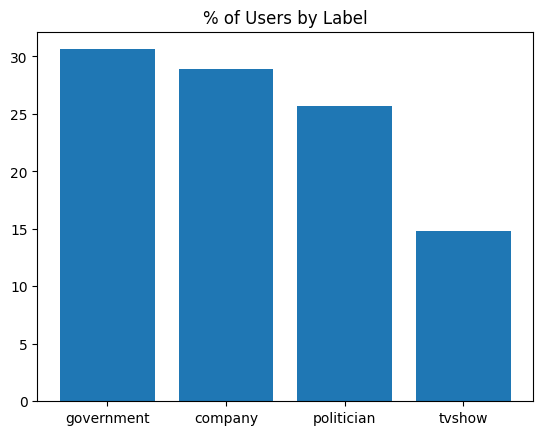

In [12]:
plt.bar(
    x=df_agg_classes.page_type.astype(str),
    height=df_agg_classes.proportion.apply(lambda x: x * 100)
)
plt.title("% of Users by Label")

In [13]:
# Import features
with open(os.path.join(data_dir, "musae_facebook_features.json"), "r") as json_file:
  features_data = json.load(json_file)

In [14]:
embeddings_len = {}

for node_id, embeddings in features_data.items():
  length = len(embeddings)
  count = embeddings_len.get(length, 0)
  count += 1
  embeddings_len[length] = count

Text(0.5, 1.0, 'Vector Size of Embeddings in features JSON file')

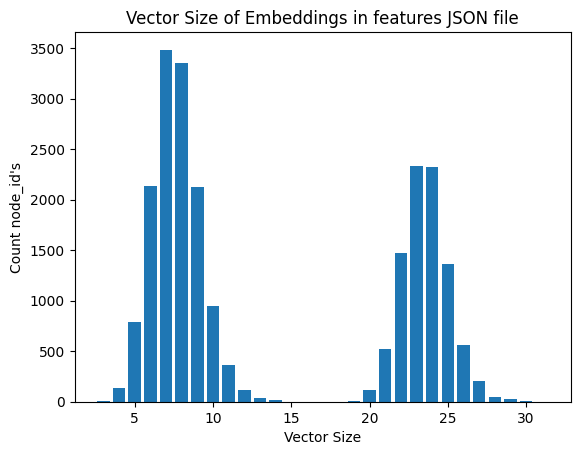

In [15]:
plt.bar(x=embeddings_len.keys(), height=embeddings_len.values())
plt.xlabel("Vector Size")
plt.ylabel("Count node_id's")
plt.title("Vector Size of Embeddings in features JSON file")

# Create PyTorch `Data` Object from CSV

In [16]:
from torch.nn.utils.rnn import pad_sequence

In [17]:
def load_node_csv(path, index_col, **kwargs):
  df = pd.read_csv(path, **kwargs)
  mapping = {i: node_id for i, node_id in enumerate(df[index_col].unique())}

  # Load node features
  with open(os.path.join(data_dir, "musae_facebook_features.json"), "r") as json_file:
    features_data = json.load(json_file)

  xs = []
  for index, node_id in mapping.items():
    features = features_data.get(str(index), [])
    if features:# Create tensor from feature vector
      features_tensor = torch.tensor(features, dtype=torch.float)
      xs.append(features_tensor)
    else:
      xs.append(torch.zeros(1, dtype=torch.float))

  # Pad features to have vectors of the same size
  padded_features = pad_sequence([torch.tensor(seq) for seq in xs], batch_first=True, padding_value=0)
  mask = padded_features != 0 # mask to indicate which features were padded

  # Create tensor of normaized features for nodes
  mean = torch.mean(padded_features[mask].float())
  std = torch.std(padded_features[mask].float())

  x = (padded_features - mean) / (std + 1e-8)  # final x tensor with normalized features

  return x

In [18]:
x = load_node_csv(path=os.path.join(data_dir, "musae_facebook_target.csv"), index_col="facebook_id")

<ipython-input-17-1784cbdc4d35>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_features = pad_sequence([torch.tensor(seq) for seq in xs], batch_first=True, padding_value=0)


In [19]:
len(x)

22470

In [20]:
def load_labels_csv(path, label_col, **kwargs):
  df = pd.read_csv(path, **kwargs)

  # Convert class_labels to numeric data types in order to create tensors
  label_categories = df[label_col].astype("category").cat.categories

  class_label_to_code = pd.DataFrame({
      "class_label": label_categories,
      "class_label_code": pd.Categorical(label_categories, categories=label_categories).codes
  })
  df["class_label_code"] = pd.Categorical(df[label_col], categories=label_categories).codes

  y = torch.tensor(df["class_label_code"].values, dtype=torch.long)

  return y

In [21]:
y = load_labels_csv(path=os.path.join(data_dir, "musae_facebook_target.csv"), label_col="page_type")

In [22]:
len(y)

22470

In [23]:
def load_edge_csv(path, src_index_col, dst_index_col, **kwargs):
  df = pd.read_csv(path, **kwargs)

  src = df[src_index_col].values
  dst = df[dst_index_col].values
  edge_index = torch.tensor([src, dst])

  return edge_index

In [24]:
edge_index = load_edge_csv(path=os.path.join(data_dir, "musae_facebook_edges.csv"), src_index_col="id_1", dst_index_col="id_2")

<ipython-input-23-7854be74538a>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.tensor([src, dst])


In [25]:
len(edge_index)

2

In [26]:
# Create homogeneous graph using PyTorch's Data object
data = Data(x=x, edge_index=edge_index, y=y)

print(data)

Data(x=[22470, 31], edge_index=[2, 171002], y=[22470])


## Train, Test and Validation dataset split

In [27]:
# Nodes
num_nodes = data.num_nodes
train_percentage = 0.7
num_train_nodes = int(train_percentage * num_nodes)

# labels
num_classes = torch.unique(data.y).size(0)
data.num_classes = num_classes

print("# of nodes: ", num_nodes, "\n# of train nodes: ", num_train_nodes, "\n# of classes: ", num_classes)

# of nodes:  22470 
# of train nodes:  15728 
# of classes:  4


In [28]:
# Create a boolean mask to indicate whether node is in training set
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[: num_train_nodes] = True

In [29]:
# Add train mask to data object
data.train_mask = train_mask

# Create test mask that is the inverse of train mask
test_mask = ~data.train_mask
data.test_mask = test_mask

data

Data(x=[22470, 31], edge_index=[2, 171002], y=[22470], num_classes=4, train_mask=[22470], test_mask=[22470])

In [30]:
# Porcentaje de nodos para validación
val_percentage = 0.1

# Número de nodos para validación
num_val_nodes = int(val_percentage * num_train_nodes)

# Crear una máscara booleana para indicar qué nodos son de validación
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[num_train_nodes:num_train_nodes+num_val_nodes] = True

# Añadir la máscara de validación al objeto data
data.val_mask = val_mask

# Crear máscara de entrenamiento que sea la inversa de la máscara de validación
train_mask = ~(data.val_mask | data.test_mask)
data.train_mask = train_mask



In [31]:
# Mostrar información
print("# of validation nodes: ", num_val_nodes)

# Actualizar el número de nodos de entrenamiento
num_train_nodes = int(train_mask.sum().item())
print("# of train nodes (after validation split): ", num_train_nodes)

num_test_nodes = int(test_mask.sum().item())
print("# of test nodes (after validation split): ", num_test_nodes)

# of validation nodes:  1572
# of train nodes (after validation split):  15728
# of test nodes (after validation split):  6742


# Build Models

In [32]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, GATConv, SAGEConv
import networkx as nx

In [33]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [34]:
def test(model, data, MLP=False):
    model.eval()
    if MLP:
      out = model(data.x)
    else:
      _, out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Count the number of predictions for each class
    class_counts = {}
    for class_label in range(data.num_classes):
        class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

    print(class_counts)

    test_acc = accuracy(pred[data.test_mask], data.y[data.test_mask])
    return test_acc

In [35]:
import plotly.graph_objects as go

def history_plot(history, plot_name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=history['epoch'], y=history['loss'], mode='lines', name='Training Loss'))
    fig.add_trace(go.Scatter(x=history['epoch'], y=history['test_acc'], mode='lines', name='Validation Accuracy'))
    fig.update_layout(
        title='Training History',
        xaxis_title='Epoch',
        yaxis_title='Value',
        legend=dict(x=0, y=1),
        template='plotly_dark'
    )
    fig.show()

In [36]:
def train(model, data, epochs=10, plot=True, plot_name = "plot", MLP=False):
    weight = torch.tensor([1 / i for i in df_agg_classes["proportion"].values], dtype=torch.float)
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    optimizer = model.optimizer

    history = {
            'epoch': [],
            'loss': [],
            'test_acc': [],
            'outputs' : []
    }

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        if MLP:
          out = model(data.x)
        else:
          _, out = model(data.x, data.edge_index)

        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        history['epoch'].append(epoch)
        history['loss'].append(loss.item())
        history['test_acc'].append(val_acc)
        history['outputs'].append(out[data.train_mask].argmax(dim=1))

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    if plot:
        history_plot(history, plot_name)

    return model

In [37]:
def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(8, 5))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="viridis")

## Build MLP

In [38]:
class MLP(torch.nn.Module):
    def __init__(self, dim_input, hidden_channels, dim_output):
        super(MLP, self).__init__()
        torch.manual_seed(42)
        self.lin1 = Linear(dim_input, hidden_channels)
        self.lin2 = Linear(hidden_channels, dim_output)
        self.dropout = 0.5
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

    def forward(self, x):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [39]:
%%time
mlp = MLP(data.num_features, 16, data.num_classes)
train(model=mlp, data=data, epochs=1000, MLP=True)
acc = test(model=mlp, data=data, MLP=True)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 2.004 | Train Acc:  25.98% | Val Loss: 1.99 | Val Acc: 27.10%
Epoch  10 | Train Loss: 1.379 | Train Acc:  33.62% | Val Loss: 1.37 | Val Acc: 34.03%
Epoch  20 | Train Loss: 1.364 | Train Acc:  34.17% | Val Loss: 1.36 | Val Acc: 34.16%
Epoch  30 | Train Loss: 1.357 | Train Acc:  35.85% | Val Loss: 1.36 | Val Acc: 35.37%
Epoch  40 | Train Loss: 1.356 | Train Acc:  33.67% | Val Loss: 1.36 | Val Acc: 33.59%
Epoch  50 | Train Loss: 1.354 | Train Acc:  35.88% | Val Loss: 1.36 | Val Acc: 34.67%
Epoch  60 | Train Loss: 1.351 | Train Acc:  35.22% | Val Loss: 1.35 | Val Acc: 35.62%
Epoch  70 | Train Loss: 1.350 | Train Acc:  36.41% | Val Loss: 1.35 | Val Acc: 35.31%
Epoch  80 | Train Loss: 1.352 | Train Acc:  36.39% | Val Loss: 1.35 | Val Acc: 36.39%
Epoch  90 | Train Loss: 1.351 | Train Acc:  36.39% | Val Loss: 1.35 | Val Acc: 36.39%
Epoch 100 | Train Loss: 1.349 | Train Acc:  37.30% | Val Loss: 1.35 | Val Acc: 36.58%
Epoch 110 | Train Loss: 1.351 | Train Acc:  36.56% | V

{0: 533, 1: 4102, 2: 1414, 3: 693}

MLP test accuracy: 40.42%

CPU times: user 30.2 s, sys: 2.42 s, total: 32.6 s
Wall time: 45.1 s


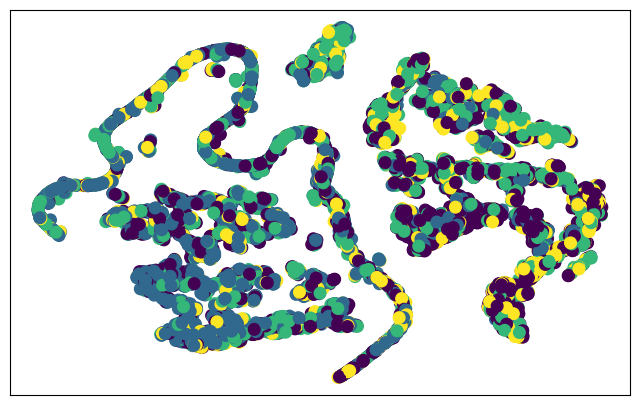

In [40]:
out = mlp(data.x)
visualize(out[data.test_mask], color=data.y[data.test_mask])

## Build GCN (Graph Convolutional Network) model

In [41]:
class GCN(torch.nn.Module):
  def __init__(self, dim_input, dim_output):
      super().__init__()
      torch.manual_seed(42)
      self.conv1 = GCNConv(dim_input, 32)
      self.conv2 = GCNConv(32, 32)
      self.conv3 = GCNConv(32, 16)
      self.conv4 = GCNConv(16, 8)
      self.conv5 = GCNConv(8, dim_output)
      self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
      x = self.conv1(x, edge_index)
      x = F.relu(x)
      x = self.conv2(x, edge_index)
      x = F.relu(x)
      x = self.conv3(x, edge_index)
      x = F.relu(x)
      x = self.conv4(x, edge_index)
      x = F.relu(x)
      x = self.conv5(x, edge_index)
      return x, F.log_softmax(x, dim=1)

In [42]:
%%time
gcn = GCN(data.num_features, data.num_classes)
train(gcn, data, 1000)
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.486 | Train Acc:  17.09% | Val Loss: 1.54 | Val Acc: 16.54%
Epoch  10 | Train Loss: 1.314 | Train Acc:  40.41% | Val Loss: 1.29 | Val Acc: 41.03%
Epoch  20 | Train Loss: 1.287 | Train Acc:  36.99% | Val Loss: 1.27 | Val Acc: 37.85%
Epoch  30 | Train Loss: 1.261 | Train Acc:  39.23% | Val Loss: 1.26 | Val Acc: 38.61%
Epoch  40 | Train Loss: 1.237 | Train Acc:  42.29% | Val Loss: 1.19 | Val Acc: 44.08%
Epoch  50 | Train Loss: 1.214 | Train Acc:  42.33% | Val Loss: 1.20 | Val Acc: 43.07%
Epoch  60 | Train Loss: 1.194 | Train Acc:  42.21% | Val Loss: 1.17 | Val Acc: 43.38%
Epoch  70 | Train Loss: 1.174 | Train Acc:  43.07% | Val Loss: 1.13 | Val Acc: 45.42%
Epoch  80 | Train Loss: 1.166 | Train Acc:  44.25% | Val Loss: 1.09 | Val Acc: 47.52%
Epoch  90 | Train Loss: 1.148 | Train Acc:  46.90% | Val Loss: 1.07 | Val Acc: 51.97%
Epoch 100 | Train Loss: 1.126 | Train Acc:  48.29% | Val Loss: 1.06 | Val Acc: 53.05%
Epoch 110 | Train Loss: 1.126 | Train Acc:  49.02% | V

{0: 1688, 1: 2140, 2: 1692, 3: 1222}

GCN test accuracy: 79.59%

CPU times: user 5min 17s, sys: 26.6 s, total: 5min 44s
Wall time: 5min 49s


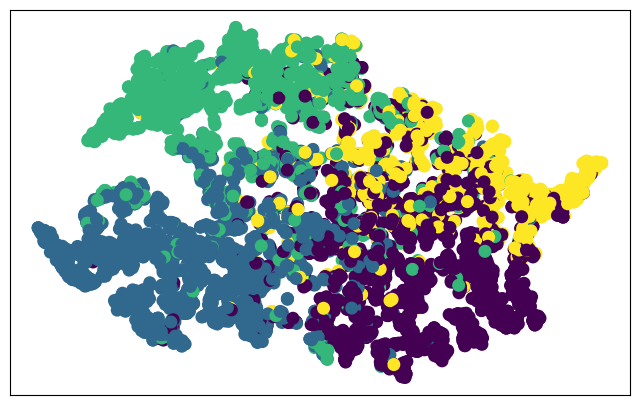

In [43]:
out,_ = gcn(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

## Build GATv2Conv model

In [44]:
class GAT(torch.nn.Module):
  def __init__(self, dim_input, dim_hidden, dim_output, heads=8):
    super().__init__()
    torch.manual_seed(42)
    self.gat1 = GATv2Conv(dim_input, dim_hidden, heads=heads)
    self.gat2 = GATv2Conv(dim_hidden*heads, dim_output, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    x = self.gat1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.gat2(x, edge_index)
    return x, F.log_softmax(x, dim=1)

In [45]:
%%time
gat = GAT(data.num_features, 16, data.num_classes)
train(gat, data, 1000)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 2.123 | Train Acc:  26.35% | Val Loss: 2.08 | Val Acc: 26.21%
Epoch  10 | Train Loss: 1.325 | Train Acc:  40.72% | Val Loss: 1.30 | Val Acc: 41.92%
Epoch  20 | Train Loss: 1.274 | Train Acc:  42.02% | Val Loss: 1.23 | Val Acc: 44.15%
Epoch  30 | Train Loss: 1.251 | Train Acc:  43.46% | Val Loss: 1.22 | Val Acc: 44.85%
Epoch  40 | Train Loss: 1.223 | Train Acc:  48.02% | Val Loss: 1.19 | Val Acc: 49.68%
Epoch  50 | Train Loss: 1.214 | Train Acc:  47.97% | Val Loss: 1.17 | Val Acc: 51.72%
Epoch  60 | Train Loss: 1.199 | Train Acc:  49.07% | Val Loss: 1.15 | Val Acc: 52.80%
Epoch  70 | Train Loss: 1.191 | Train Acc:  49.27% | Val Loss: 1.15 | Val Acc: 53.18%
Epoch  80 | Train Loss: 1.174 | Train Acc:  50.29% | Val Loss: 1.12 | Val Acc: 53.44%
Epoch  90 | Train Loss: 1.159 | Train Acc:  50.87% | Val Loss: 1.10 | Val Acc: 53.56%
Epoch 100 | Train Loss: 1.146 | Train Acc:  51.41% | Val Loss: 1.09 | Val Acc: 55.09%
Epoch 110 | Train Loss: 1.151 | Train Acc:  51.68% | V

{0: 1731, 1: 2349, 2: 1711, 3: 951}

GAT test accuracy: 71.66%

CPU times: user 14min 44s, sys: 17min 51s, total: 32min 36s
Wall time: 33min 9s


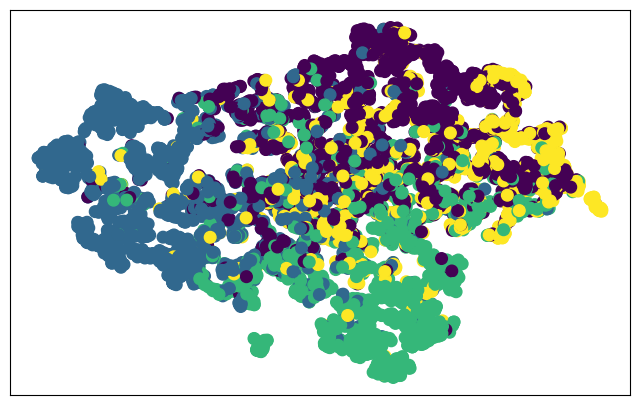

In [46]:
out,_ = gat(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

## Build GATConv model

In [47]:
class GATc(torch.nn.Module):
  def __init__(self, dim_input, dim_output):
    super().__init__()
    torch.manual_seed(42)
    self.conv1 = GATConv(in_channels=dim_input, out_channels=32, heads=32)
    self.conv2 = GATConv(in_channels=32 * 32, out_channels=16, heads=16)
    self.conv3 = GATConv(in_channels=16 * 16, out_channels=8, heads=8)
    self.conv4 = GATConv(in_channels=8 * 8, out_channels=4, heads=4)
    self.conv5 = GATConv(in_channels=4 * 4, out_channels=dim_output)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)
    x = F.relu(x)
    x = self.conv4(x, edge_index)
    x = F.relu(x)
    x = self.conv5(x, edge_index)
    return x, F.log_softmax(x, dim=1)

In [50]:
%%time
gat2 = GATc(data.num_features, data.num_classes)
train(gat2, data, 100)
acc = test(gat2, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.395 | Train Acc:  24.78% | Val Loss: 1.39 | Val Acc: 25.51%
Epoch  10 | Train Loss: 1.352 | Train Acc:  36.12% | Val Loss: 1.35 | Val Acc: 36.83%
Epoch  20 | Train Loss: 1.315 | Train Acc:  35.76% | Val Loss: 1.30 | Val Acc: 37.53%
Epoch  30 | Train Loss: 1.268 | Train Acc:  38.99% | Val Loss: 1.22 | Val Acc: 41.09%
Epoch  40 | Train Loss: 1.235 | Train Acc:  44.51% | Val Loss: 1.23 | Val Acc: 44.27%
Epoch  50 | Train Loss: 1.176 | Train Acc:  48.00% | Val Loss: 1.08 | Val Acc: 54.07%
Epoch  60 | Train Loss: 1.145 | Train Acc:  49.75% | Val Loss: 1.07 | Val Acc: 56.11%
Epoch  70 | Train Loss: 1.089 | Train Acc:  50.46% | Val Loss: 1.02 | Val Acc: 51.84%
Epoch  80 | Train Loss: 1.088 | Train Acc:  50.91% | Val Loss: 1.05 | Val Acc: 51.15%
Epoch  90 | Train Loss: 1.027 | Train Acc:  56.39% | Val Loss: 0.89 | Val Acc: 63.23%
Epoch 100 | Train Loss: 1.033 | Train Acc:  56.00% | Val Loss: 0.88 | Val Acc: 61.51%


{0: 624, 1: 3316, 2: 1406, 3: 1396}

GAT test accuracy: 58.17%

CPU times: user 6min 47s, sys: 8min 14s, total: 15min 1s
Wall time: 15min 7s


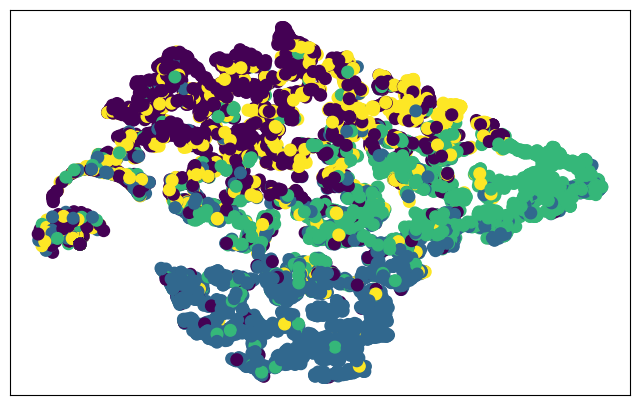

In [51]:
out,_ = gat2(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

## Build GraphSAGE

In [ ]:
def test(model, data, MLP=False):
    model.eval()
    if MLP:
      out = model(data.x)
    else:
      _, out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Count the number of predictions for each class
    class_counts = {}
    for class_label in range(data.num_classes):
        class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

    print(class_counts)

    test_acc = accuracy(pred[data.test_mask], data.y[data.test_mask])
    return test_acc


def train(model, data, epochs=10, plot=True, plot_name = "plot", MLP=False):
    weight = torch.tensor([1 / i for i in df_agg_classes["proportion"].values], dtype=torch.float)
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    optimizer = model.optimizer

    history = {
            'epoch': [],
            'loss': [],
            'test_acc': [],
            'outputs' : []
    }

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        if MLP:
          out = model(data.x)
        else:
          _, out = model(data.x, data.edge_index)

        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        history['epoch'].append(epoch)
        history['loss'].append(loss.item())
        history['test_acc'].append(val_acc)
        history['outputs'].append(out[data.train_mask].argmax(dim=1))

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    if plot:
        history_plot(history, plot_name)

    return model

In [63]:
data

Data(x=[22470, 31], edge_index=[2, 171002], y=[22470], num_classes=4, train_mask=[22470], test_mask=[22470], val_mask=[22470])

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning:

Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling



Subgraph 0: Data(x=[5484, 31], edge_index=[2, 8177], y=[5484], num_classes=4, train_mask=[5484], test_mask=[5484], val_mask=[5484], n_id=[5484], e_id=[8177], input_id=[3932], batch_size=3932)
Subgraph 1: Data(x=[8294, 31], edge_index=[2, 18409], y=[8294], num_classes=4, train_mask=[8294], test_mask=[8294], val_mask=[8294], n_id=[8294], e_id=[18409], input_id=[3932], batch_size=3932)
Subgraph 2: Data(x=[10429, 31], edge_index=[2, 27524], y=[10429], num_classes=4, train_mask=[10429], test_mask=[10429], val_mask=[10429], n_id=[10429], e_id=[27524], input_id=[3932], batch_size=3932)
Subgraph 3: Data(x=[12270, 31], edge_index=[2, 35956], y=[12270], num_classes=4, train_mask=[12270], test_mask=[12270], val_mask=[12270], n_id=[12270], e_id=[35956], input_id=[3932], batch_size=3932)


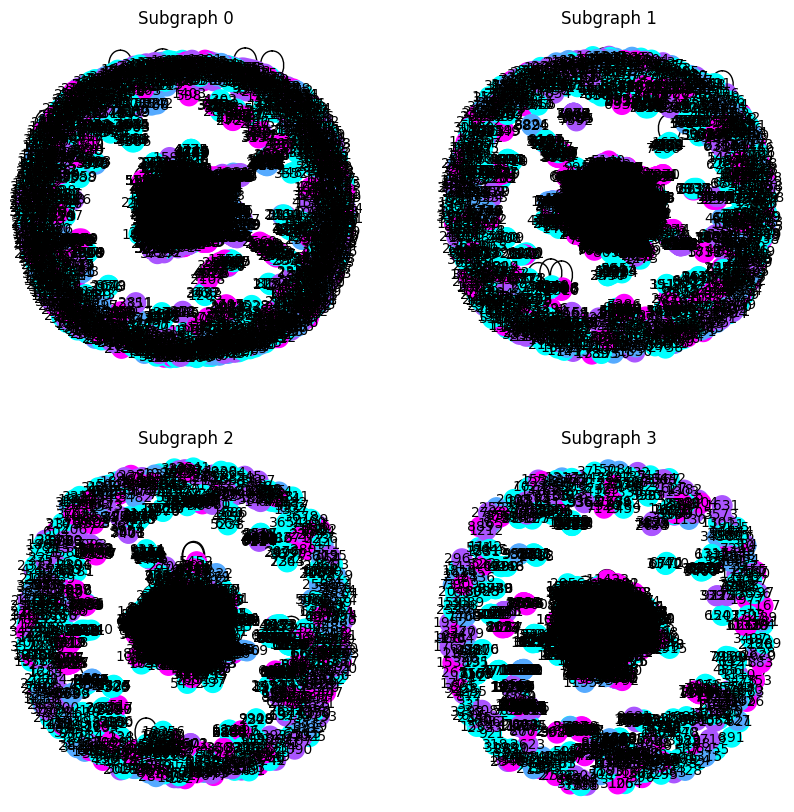

In [64]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

batch_size = len(data.train_mask.nonzero(as_tuple=False)) // 4

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=batch_size,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(10,10))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

Creamos cuatro subgrafos de varios tamaños. Nos permite procesarlos en paralelo y es más fácil procesarlos.

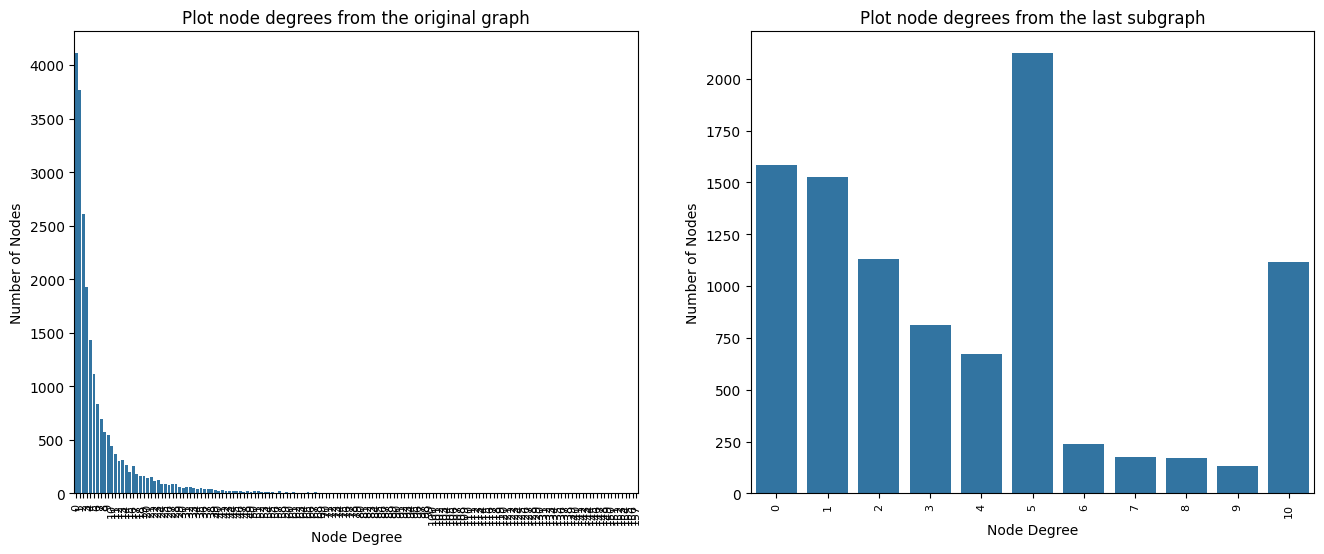

In [65]:
from torch_geometric.utils import degree
from collections import Counter
import seaborn as sns
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def plot_degree(data, index, title):
    # Obtener lista de grados para cada nodo
    degrees = degree(data.edge_index[index]).numpy()
    # Contar el número de nodos para cada grado
    numbers = Counter(degrees)
    # Convertir los datos a un DataFrame de pandas
    degree_df = pd.DataFrame.from_dict(numbers, orient='index').reset_index()
    degree_df.columns = ['Degree', 'Count']
    sns.barplot(ax=axes[index], x='Degree', y='Count', data=degree_df)
    axes[index].set_xlabel('Node Degree')
    axes[index].set_ylabel('Number of Nodes')
    axes[index].set_title(title)
    axes[index].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axes[index].tick_params(axis='x', labelsize=8)
    axes[index].tick_params(axis='y', labelsize=10)
    axes[index].set_xticks(range(len(degree_df)))
    axes[index].set_xticklabels(axes[index].get_xticklabels(), rotation=90)

plot_degree(data,0,'Plot node degrees from the original graph')
plot_degree(subdata,1,'Plot node degrees from the last subgraph')

El primer gráfico muestra la distribución original de los grados de los nodos, mientras que el segundo muestra la distribución obtenida después del muestreo de vecinos. En este ejemplo, elegimos considerar solo cinco vecinos, que es mucho menor que el valor máximo original. Es importante recordar este compromiso al hablar sobre GraphSAGE.

PinSAGE propone otra solución. En lugar de muestreo de vecinos, PinSAGE simula caminatas aleatorias para cada nodo, lo que captura una representación mejor de sus vecindarios. Luego, selecciona un número predefinido de vecinos con el mayor número de visitas. Esta técnica permite a PinSAGE considerar la importancia de cada vecino mientras controla el tamaño del grafo de computación.

In [66]:
class GraphSAGE(torch.nn.Module):
  def __init__(self, dim_input, dim_hidden, dim_output):
    super().__init__()
    self.sage1 = SAGEConv(dim_input, dim_hidden)
    self.sage2 = SAGEConv(dim_hidden, dim_output)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu()
    h = F.dropout(h, p=0.1, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    weight = torch.tensor([1 / i for i in df_agg_classes["proportion"].values], dtype=torch.float)
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

In [67]:
@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

Con GraphSAGE, recorremos lotes (nuestros cuatro subgrafos) creados por el proceso de muestreo vecino. La forma en que calculamos la precisión y la pérdida de validación también es diferente por eso.

In [69]:
%%time

# Create GraphSAGE
graphsage = GraphSAGE(data.num_features, 64, data.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 1000)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(31, 64, aggr=mean)
  (sage2): SAGEConv(64, 4, aggr=mean)
)
Epoch   0 | Train Loss: 1.390 | Train Acc:  34.64% | Val Loss: 1.37 | Val Acc: 39.76%
Epoch  10 | Train Loss: 1.217 | Train Acc:  47.46% | Val Loss: 1.21 | Val Acc: 49.69%
Epoch  20 | Train Loss: 1.172 | Train Acc:  50.51% | Val Loss: 1.20 | Val Acc: 48.62%
Epoch  30 | Train Loss: 1.143 | Train Acc:  52.06% | Val Loss: 1.17 | Val Acc: 50.69%
Epoch  40 | Train Loss: 1.119 | Train Acc:  53.19% | Val Loss: 1.19 | Val Acc: 50.73%
Epoch  50 | Train Loss: 1.100 | Train Acc:  54.36% | Val Loss: 1.16 | Val Acc: 49.26%
Epoch  60 | Train Loss: 1.085 | Train Acc:  55.15% | Val Loss: 1.16 | Val Acc: 50.98%
Epoch  70 | Train Loss: 1.077 | Train Acc:  55.68% | Val Loss: 1.14 | Val Acc: 54.16%
Epoch  80 | Train Loss: 1.068 | Train Acc:  55.80% | Val Loss: 1.14 | Val Acc: 50.49%
Epoch  90 | Train Loss: 1.046 | Train Acc:  56.95% | Val Loss: 1.14 | Val Acc: 51.27%
Epoch 100 | Train Loss: 1.041 | Train Acc:  57.26%

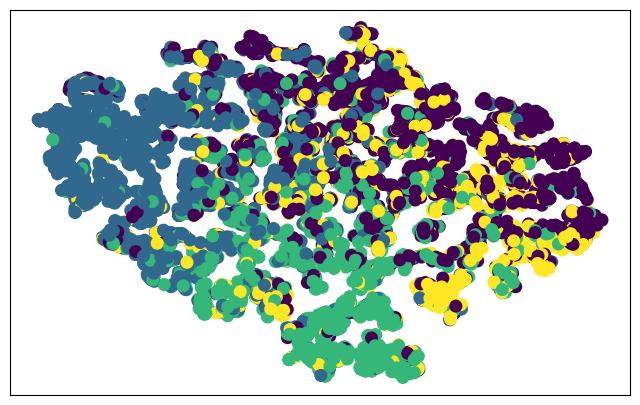

In [71]:
out = graphsage(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])